In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image
import os
import albumentations as A
from tensorflow_examples.models.pix2pix import pix2pix

In [3]:
if tf.test.is_gpu_available():
    print('Using GPU. Good to go!')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Using GPU. Good to go!


# **Train the traditional U-Net model with Oxford-IIIT pet dataset**

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteL5D3RC/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteL5D3RC/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


**Define Functions for Data Preprocessing**

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [6]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [7]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

**Load the Dataset**

In [8]:
TOTAL_LENGTH = info.splits['train'].num_examples + info.splits['test'].num_examples
TRAIN_LENGTH = int(TOTAL_LENGTH * 0.7)
VAL_LENGTH = int(TOTAL_LENGTH * 0.2)
TEST_LENGTH = int(TOTAL_LENGTH * 0.1)
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
print(TRAIN_LENGTH, VAL_LENGTH, TEST_LENGTH)

5144 1469 734


In [10]:
total_ds = dataset['train'].concatenate(dataset['test'])
total_ds = total_ds.shuffle(BUFFER_SIZE)

In [11]:
train = total_ds.take(TRAIN_LENGTH).map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
val = total_ds.skip(TRAIN_LENGTH).take(VAL_LENGTH).map(load_image_test)
test = total_ds.skip(TRAIN_LENGTH + VAL_LENGTH).map(load_image_test)

In [12]:
print(train)
print(len(train))
print(val)
print(len(val))
print(test)
print(len(test))

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
5144
<MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
1469
<MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
736


In [13]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val.cache().batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [14]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


**Display Sample Data**

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

(128, 128, 1)


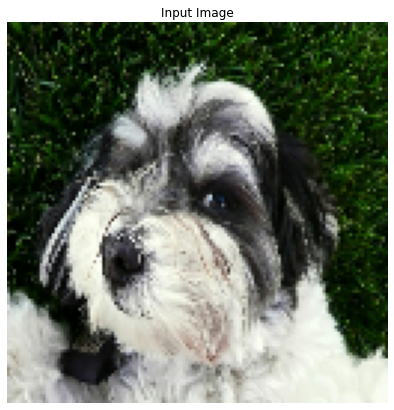

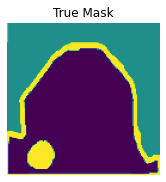

(128, 128, 1)


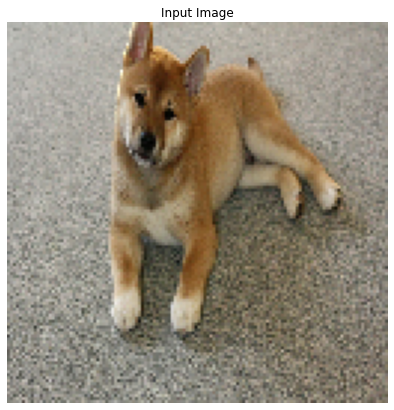

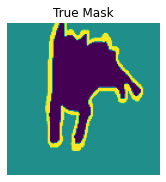

(128, 128, 1)


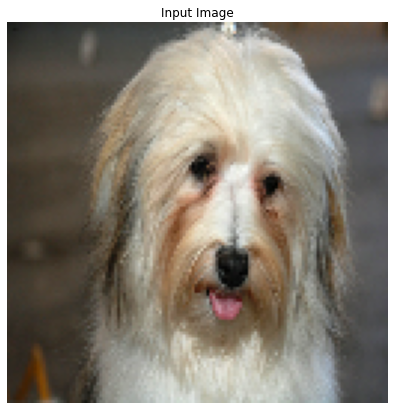

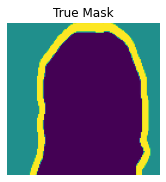

In [16]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    print(np.shape(sample_mask))
    display([sample_image, sample_mask])

for image, mask in val.take(1):
    sample_image, sample_mask = image, mask
    print(np.shape(sample_mask))
    display([sample_image, sample_mask])

for image, mask in test.take(1):
    sample_image, sample_mask = image, mask
    print(np.shape(sample_mask))
    display([sample_image, sample_mask])

**Implment the U-Net Model**

In [17]:
class UNetBlock(tf.keras.Model):
    def __init__(self, img_rows=256, img_cols=256):
        super(UNetBlock, self).__init__()
        self.img_rows = img_rows
        self.img_cols = img_cols
        
        ########################################################################
        # Implement UNet Model                                                 #
        ########################################################################
        # First set of conv layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                           kernel_initializer = 'he_normal')
        self.conv2 = tf.keras.layers.Conv2D(64, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                           kernel_initializer = 'he_normal')
            
        # MaxPool reduce the size by half
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, 
                                    data_format='channels_last')
        
        # Add Dropout layer
        self.dropout1 = tf.keras.layers.Dropout(0.25)
            
        # Second set of conv layers
        self.conv3 = tf.keras.layers.Conv2D(128, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                           kernel_initializer = 'he_normal')
        self.conv4 = tf.keras.layers.Conv2D(128, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                           kernel_initializer = 'he_normal')
            
        # MaxPool reduce the size by half
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, 
                                    data_format='channels_last')
        
        # Add Dropout layer
        self.dropout2 = tf.keras.layers.Dropout(0.5)
            
        # Third set of conv layers
        self.conv5 = tf.keras.layers.Conv2D(256, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                           kernel_initializer = 'he_normal')
        self.conv6 = tf.keras.layers.Conv2D(256, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                           kernel_initializer = 'he_normal')
            
        # MaxPool reduce the size by half
        self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, 
                                    data_format='channels_last')
        
        # Add Dropout layer
        self.dropout3 = tf.keras.layers.Dropout(0.5)
            
        # Fourth set of conv layers
        self.conv7 = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                           kernel_initializer = 'he_normal')
        self.conv8 = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                           kernel_initializer = 'he_normal')
        
        # MaxPool reduce the size by half
        self.maxpool4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, 
                                    data_format='channels_last')
        
        # Add Dropout layer
        self.dropout4 = tf.keras.layers.Dropout(0.5)
        
        # Fifth set of conv layers
        self.conv9 = tf.keras.layers.Conv2D(1024, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                           kernel_initializer = 'he_normal')
        self.conv10 = tf.keras.layers.Conv2D(1024, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                            kernel_initializer = 'he_normal')
            
        # Deconv layer
        self.deconv1 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")
        
        # Add Dropout layer
        self.dropout5 = tf.keras.layers.Dropout(0.5)

        # Sxith set of conv layers
        self.conv11 = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                            kernel_initializer = 'he_normal')
        self.conv12 = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                            kernel_initializer = 'he_normal')
        
        # Upsample double the size
        self.deconv2 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")

        # Add Dropout layer
        self.dropout6 = tf.keras.layers.Dropout(0.5)
        
        # Seventh set of conv layers
        self.conv13 = tf.keras.layers.Conv2D(256, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                            kernel_initializer = 'he_normal')
        self.conv14 = tf.keras.layers.Conv2D(256, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                            kernel_initializer = 'he_normal')
        
        # Upsample double the size
        self.deconv3 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")

        # Add Dropout layer
        self.dropout7 = tf.keras.layers.Dropout(0.5)
        
        # Eighth set of conv layers
        self.conv15 = tf.keras.layers.Conv2D(128, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                            kernel_initializer = 'he_normal')
        self.conv16 = tf.keras.layers.Conv2D(128, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                            kernel_initializer = 'he_normal')
        
        # Upsample double the size
        self.deconv4 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")

        # Add Dropout layer
        self.dropout8 = tf.keras.layers.Dropout(0.5)
        
        # Ninth set of conv layers
        self.conv17 = tf.keras.layers.Conv2D(64, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                            kernel_initializer = 'he_normal')
        self.conv18 = tf.keras.layers.Conv2D(64, 3, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='relu',
                                            kernel_initializer = 'he_normal')
        
        # Tenth set of conv layers
        self.conv19 = tf.keras.layers.Conv2D(3, 1, strides=(1, 1), padding="same",
                                data_format="channels_last", activation='sigmoid')
    
        
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.conv2(x)
        copy1 = x
        
        x = self.maxpool1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        copy2 = x
        
        x = self.maxpool2(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        copy3 = x
        
        x = self.maxpool3(x)
        
        x = self.conv7(x)
        x = self.conv8(x)
        copy4 = x
        
        x = self.maxpool4(x)
        
        x = self.conv9(x)
        x = self.conv10(x)
        
        x = self.deconv1(x)
        x = tf.keras.layers.Concatenate()([copy4, x])
        x = self.conv11(x)
        x = self.conv12(x)
        
        x = self.deconv2(x)
        x = tf.keras.layers.Concatenate()([copy3, x])
        x = self.conv13(x)
        x = self.conv14(x)
        
        x = self.deconv3(x)
        x = tf.keras.layers.Concatenate()([copy2, x])
        x = self.conv15(x)
        x = self.conv16(x)
        
        x = self.deconv4(x)
        x = tf.keras.layers.Concatenate()([copy1, x])
        x = self.conv17(x)
        x = self.conv18(x)
        
        x = self.conv19(x)
        
        return x
    
    def model(self):
        x = tf.keras.Input(shape=(self.img_rows, self.img_cols, 3))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
        

In [21]:
block = UNetBlock(128, 128)
block.model().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_19[0][0]']              
                                )                                                           

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

**Training Process**

In [23]:
# Train the model
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

block.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_history = block.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=val_dataset)

Epoch 1/15
160/160 [==============================] - 84s 521ms/step - loss: 0.8857 - accuracy: 0.6397 - val_loss: 0.6734 - val_accuracy: 0.7131
Epoch 2/15
160/160 [==============================] - 75s 432ms/step - loss: 0.6132 - accuracy: 0.7445 - val_loss: 0.5380 - val_accuracy: 0.7797
Epoch 3/15
160/160 [==============================] - 69s 429ms/step - loss: 0.4881 - accuracy: 0.8019 - val_loss: 0.5108 - val_accuracy: 0.7969
Epoch 4/15
160/160 [==============================] - 68s 428ms/step - loss: 0.4182 - accuracy: 0.8309 - val_loss: 0.4062 - val_accuracy: 0.8346
Epoch 5/15
160/160 [==============================] - 69s 429ms/step - loss: 0.3897 - accuracy: 0.8427 - val_loss: 0.3811 - val_accuracy: 0.8475
Epoch 6/15
160/160 [==============================] - 68s 428ms/step - loss: 0.3585 - accuracy: 0.8549 - val_loss: 0.3448 - val_accuracy: 0.8618
Epoch 7/15
160/160 [==============================] - 69s 429ms/step - loss: 0.3309 - accuracy: 0.8654 - val_loss: 0.3339 - val_ac

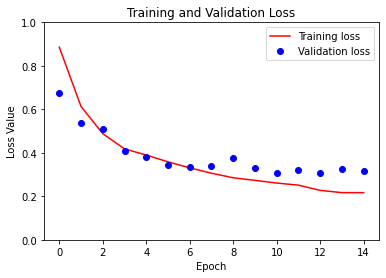

In [24]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

**Display Training Result**

In [25]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [26]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask','Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [27]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = block.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(block.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 413ms/step


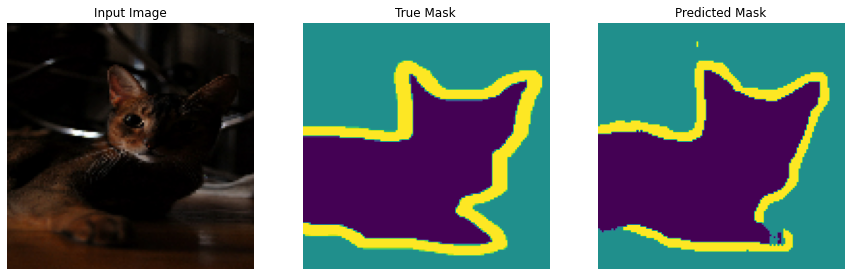

1/1 [==============================] - 0s 19ms/step


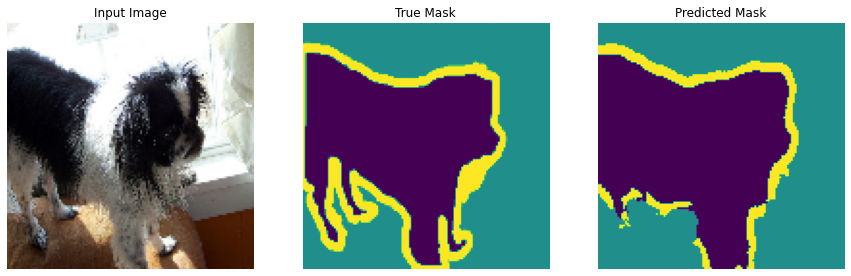

1/1 [==============================] - 0s 24ms/step


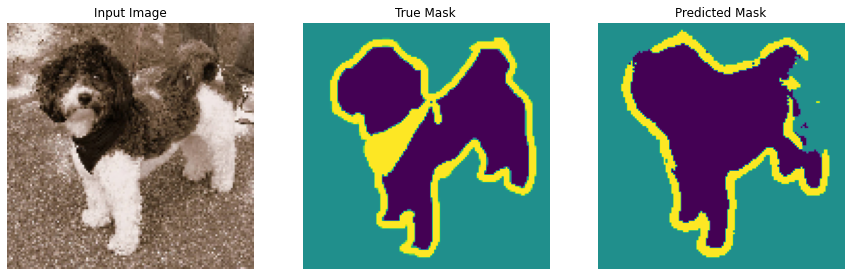

1/1 [==============================] - 0s 29ms/step


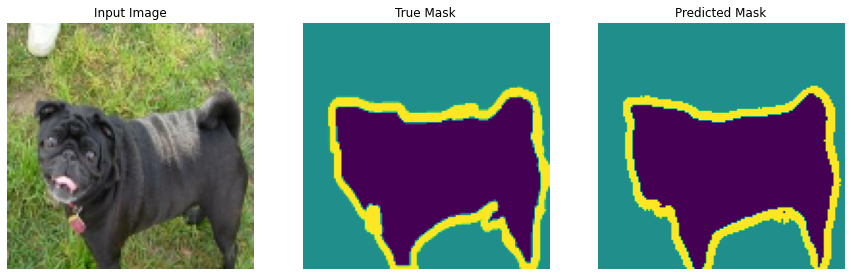

1/1 [==============================] - 0s 31ms/step


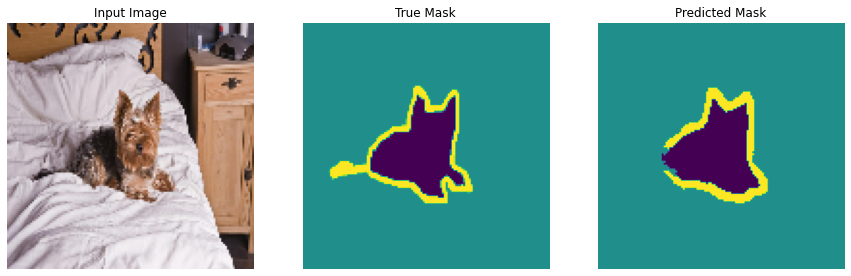

---------
1/1 [==============================] - 0s 27ms/step


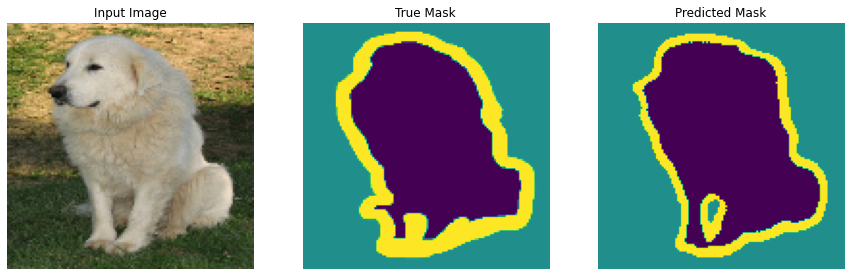

1/1 [==============================] - 0s 25ms/step


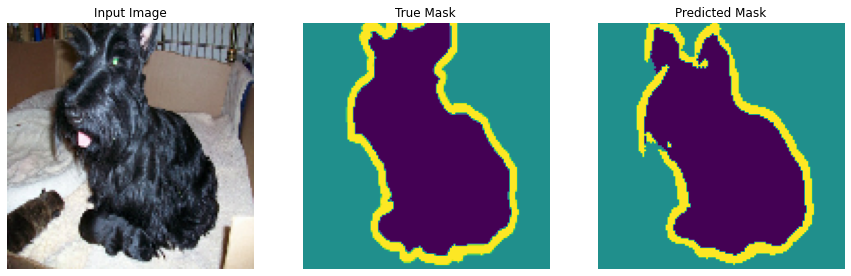

1/1 [==============================] - 0s 29ms/step


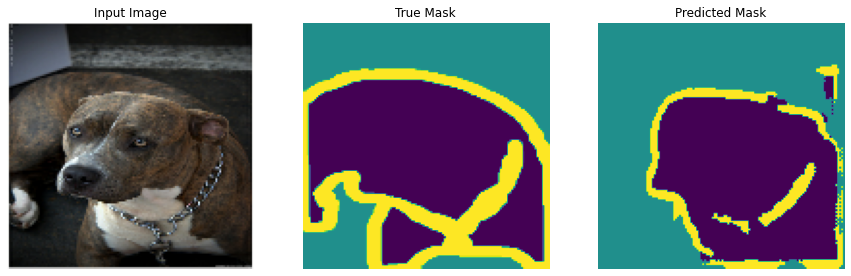

1/1 [==============================] - 0s 26ms/step


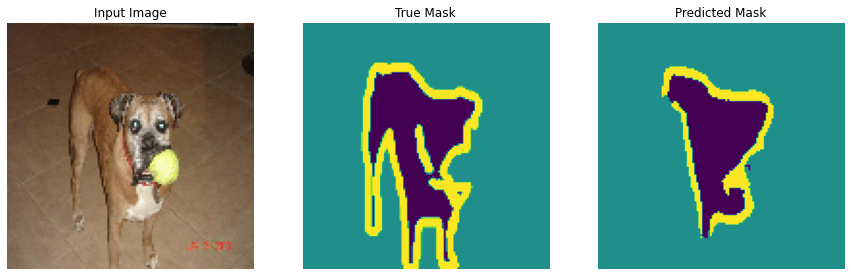

1/1 [==============================] - 0s 19ms/step


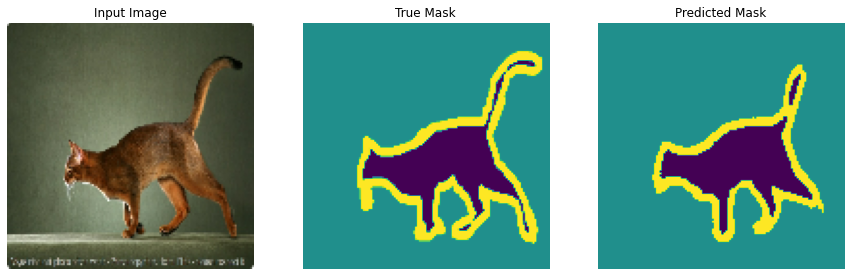

In [28]:
show_predictions(train_dataset, 5)
print('---------')
show_predictions(val_dataset, 5)

**Display Testing Result**

In [29]:
block.evaluate(test_dataset)

23/23 [==============================] - 20s 138ms/step - loss: 0.3116 - accuracy: 0.8807


[0.31164446473121643, 0.8807100057601929]

1/1 [==============================] - 0s 23ms/step


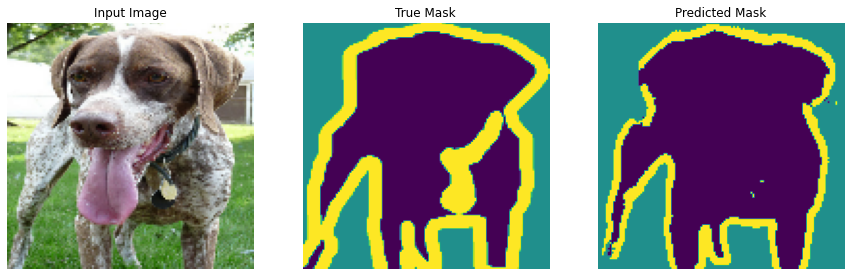

1/1 [==============================] - 0s 25ms/step


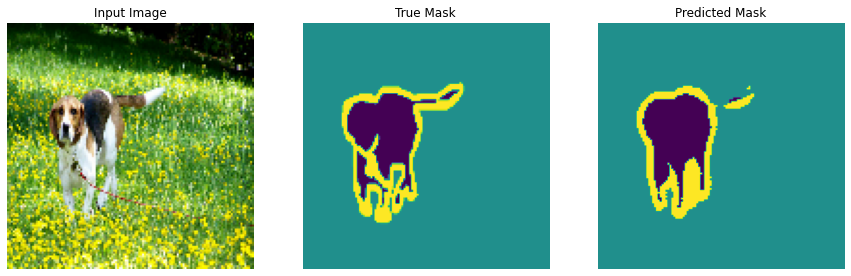

1/1 [==============================] - 0s 30ms/step


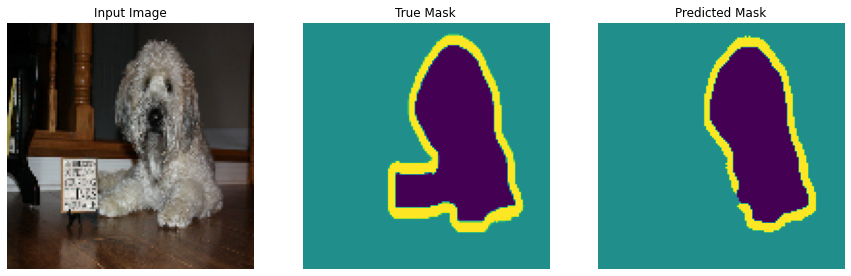

1/1 [==============================] - 0s 25ms/step


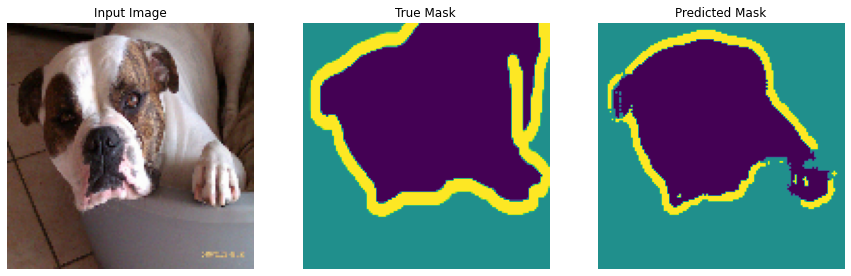

1/1 [==============================] - 0s 25ms/step


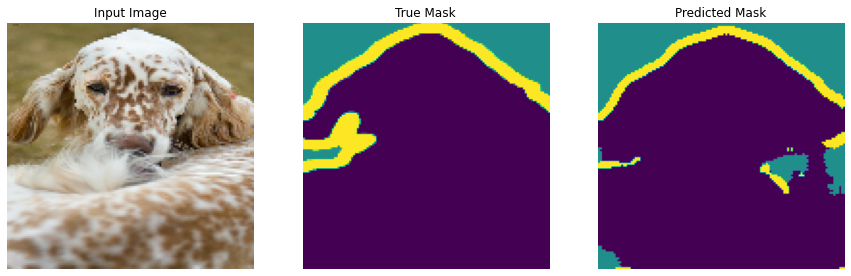

In [30]:
show_predictions(test_dataset, 5)

**Test on our own image**

In [31]:
def preprocess(input_image):
    input_image = tf.keras.preprocessing.image.img_to_array(input_image)
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image = input_image[np.newaxis, ...]
    return input_image

In [32]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
      plt.axis('off')

    plt.show()

(1, 128, 128, 3)
1/1 [==============================] - 0s 18ms/step


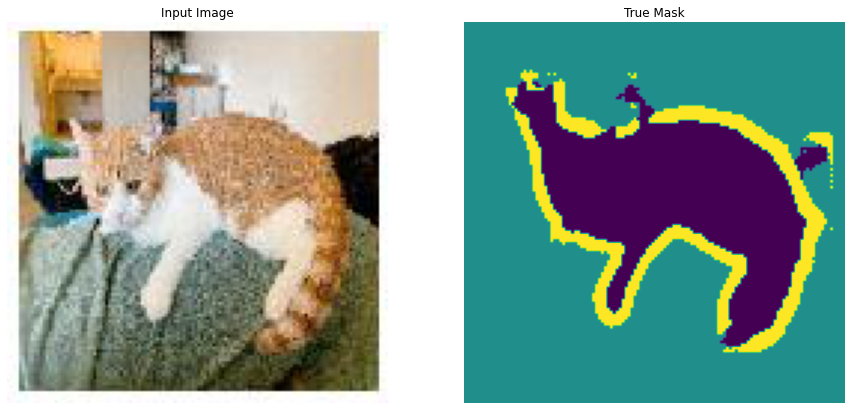

In [34]:
# Load our own image
path = "img3.jpg"
img = tf.keras.preprocessing.image.load_img(path, target_size=(128, 128))
img = preprocess(img)
print(np.shape(img))

# Make predictions on this image
pred = block.predict(img)
pred_mask = create_mask(pred)
#pred_path = "pred_img.jpg"
#tf.keras.preprocessing.image.save_img(pred_path, pred_mask)
display([img[0], pred_mask])

## **U-Net Model with Pre-trained Encoder**

**Define Pre-trained Encoder**

In [36]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)

# Define activation functions
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Encoder
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [37]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [38]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = inputs

    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [39]:
OUTPUT_CHANNELS = 22
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

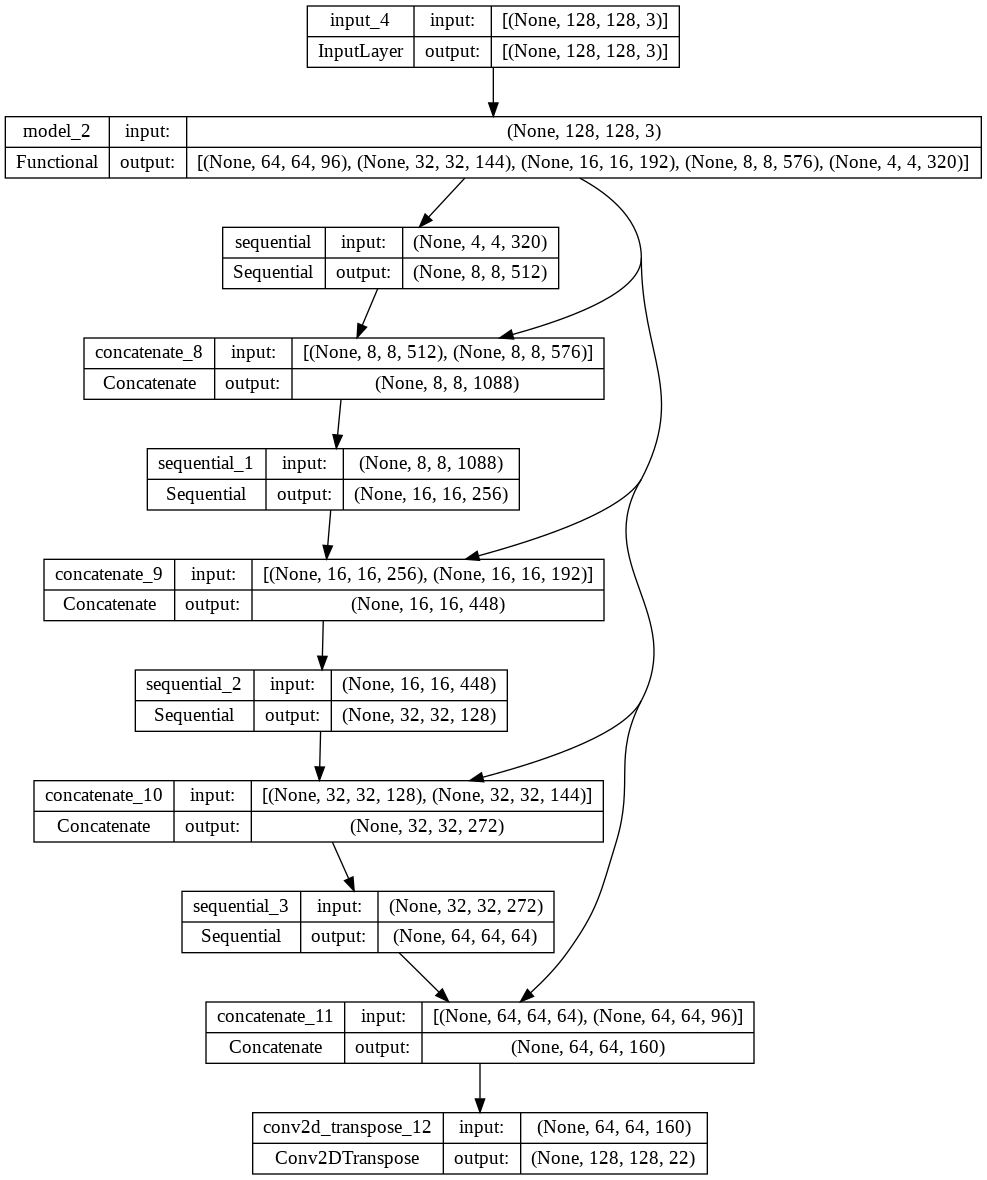

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True)

**Training Process**

In [41]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [42]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [43]:
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/15
160/160 [==============================] - 32s 174ms/step - loss: 0.4468 - accuracy: 0.8354 - val_loss: 0.2800 - val_accuracy: 0.8869
Epoch 2/15
160/160 [==============================] - 29s 175ms/step - loss: 0.2770 - accuracy: 0.8863 - val_loss: 0.2603 - val_accuracy: 0.8955
Epoch 3/15
160/160 [==============================] - 28s 175ms/step - loss: 0.2592 - accuracy: 0.8922 - val_loss: 0.2274 - val_accuracy: 0.9059
Epoch 4/15
160/160 [==============================] - 27s 168ms/step - loss: 0.2489 - accuracy: 0.8958 - val_loss: 0.2576 - val_accuracy: 0.8923
Epoch 5/15
160/160 [==============================] - 27s 169ms/step - loss: 0.2397 - accuracy: 0.8989 - val_loss: 0.2583 - val_accuracy: 0.8932
Epoch 6/15
160/160 [==============================] - 28s 175ms/step - loss: 0.2343 - accuracy: 0.9011 - val_loss: 0.2317 - val_accuracy: 0.9018
Epoch 7/15
160/160 [==============================] - 27s 171ms/step - loss: 0.2271 - accuracy: 0.9035 - val_loss: 0.2387 - val_ac

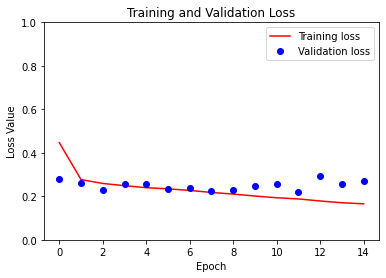

In [44]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

**Display Training Result**

In [46]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [47]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask','Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [48]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 737ms/step


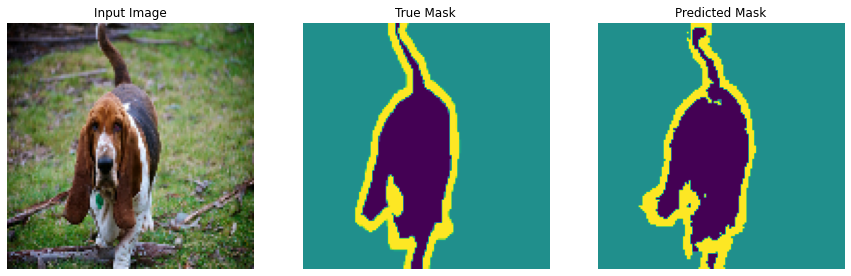

1/1 [==============================] - 0s 25ms/step


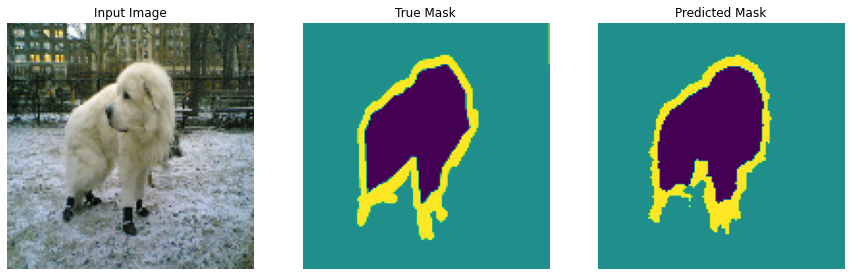

1/1 [==============================] - 0s 33ms/step


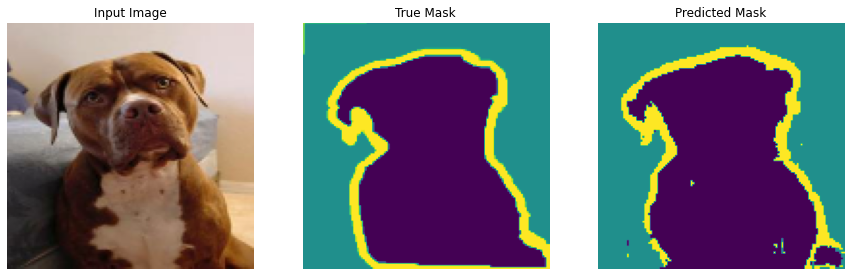

1/1 [==============================] - 0s 26ms/step


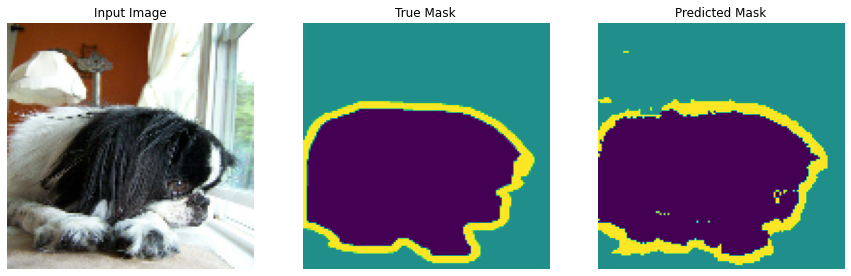

1/1 [==============================] - 0s 24ms/step


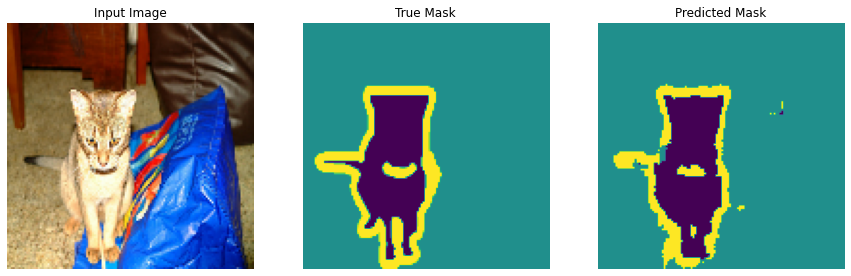

---------
1/1 [==============================] - 0s 23ms/step


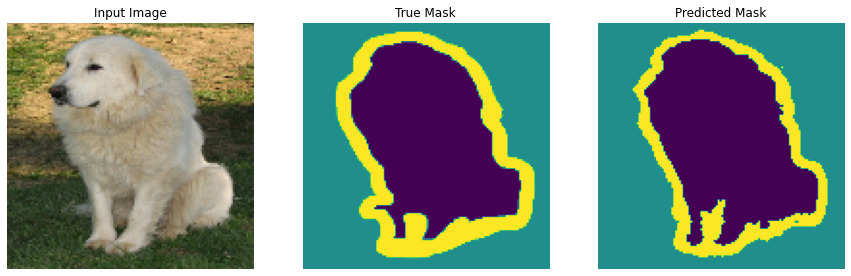

1/1 [==============================] - 0s 35ms/step


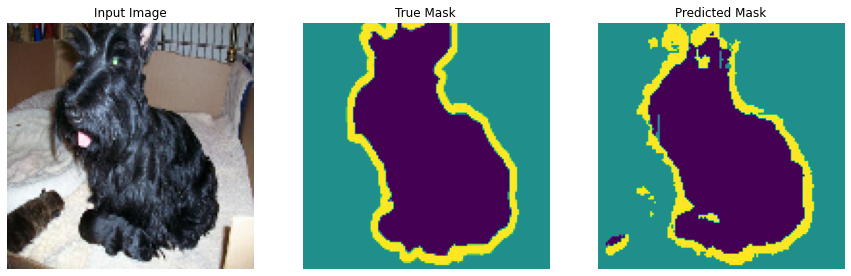

1/1 [==============================] - 0s 30ms/step


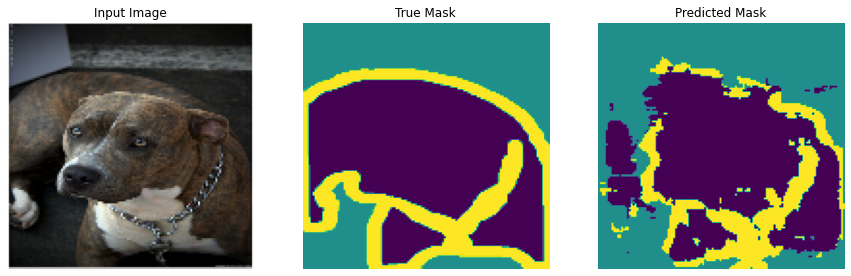

1/1 [==============================] - 0s 32ms/step


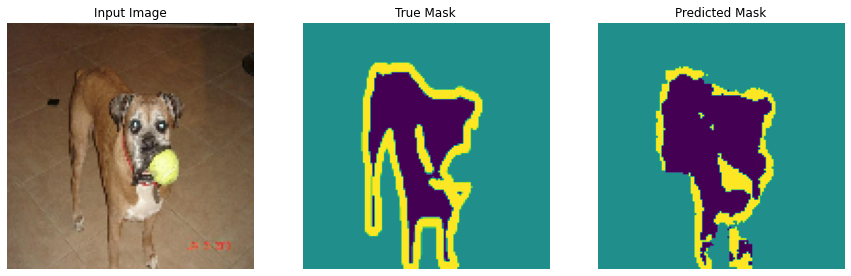

1/1 [==============================] - 0s 27ms/step


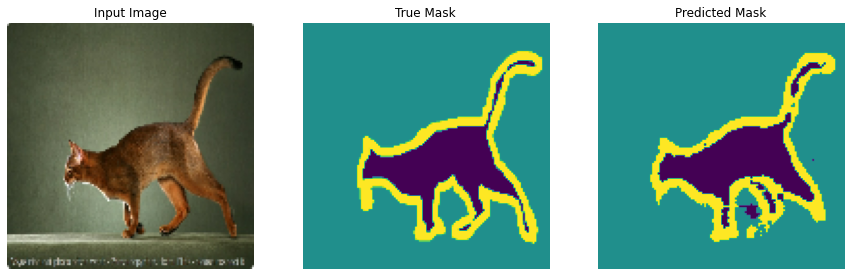

In [49]:
show_predictions(train_dataset, 5)
print('---------')
show_predictions(val_dataset, 5)

**Display Testing Result**

In [50]:
block.evaluate(test_dataset)

23/23 [==============================] - 17s 136ms/step - loss: 0.3152 - accuracy: 0.8809


[0.31517699360847473, 0.8809078931808472]

1/1 [==============================] - 0s 26ms/step


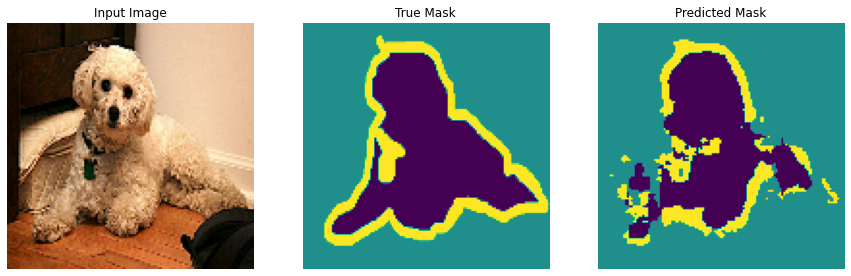

1/1 [==============================] - 0s 30ms/step


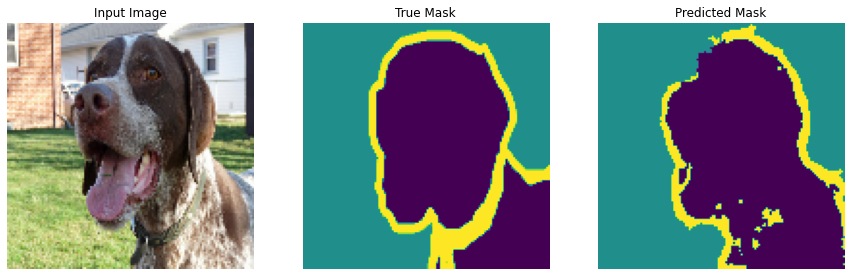

1/1 [==============================] - 0s 27ms/step


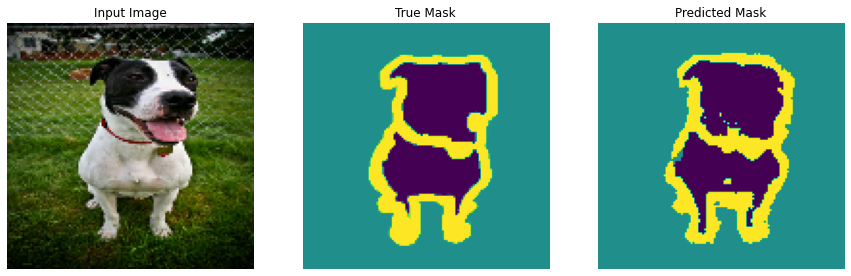

1/1 [==============================] - 0s 33ms/step


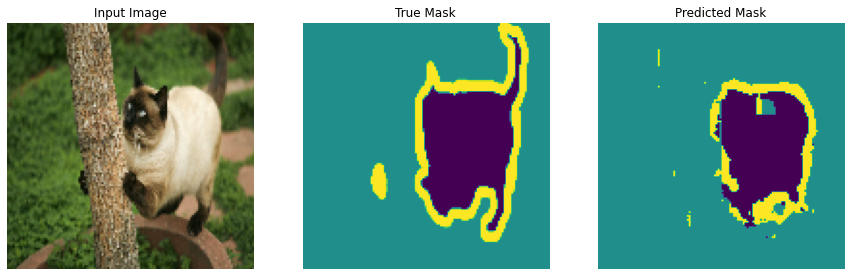

1/1 [==============================] - 0s 24ms/step


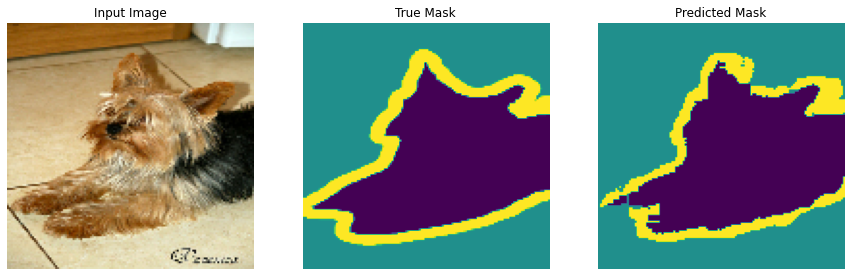

In [51]:
show_predictions(test_dataset, 5)

(1, 128, 128, 3)
1/1 [==============================] - 0s 18ms/step


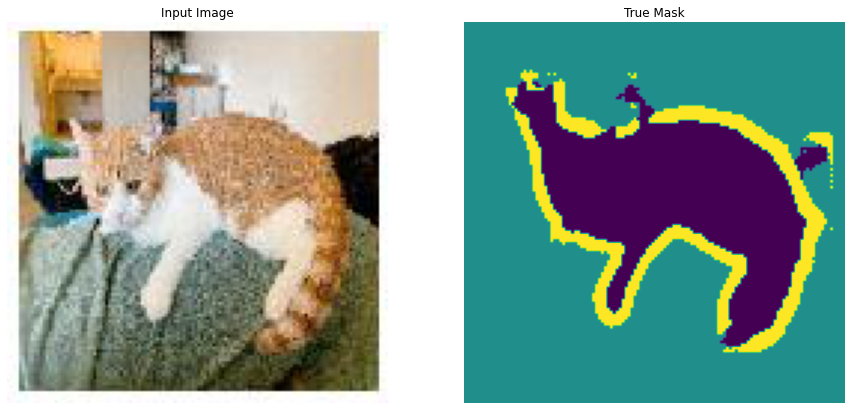

In [52]:
# Load our own image
path = "img3.jpg"
img = tf.keras.preprocessing.image.load_img(path, target_size=(128, 128))
img = preprocess(img)
print(np.shape(img))

# Make predictions on this image
pred = block.predict(img)
pred_mask = create_mask(pred)
#pred_path = "pred_img.jpg"
#tf.keras.preprocessing.image.save_img(pred_path, pred_mask)
display([img[0], pred_mask])